In [8]:
import os
import glob
import unicodedata
import string
import torch

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

# Load data into category_lines
category_lines = {}
all_categories = []

for filename in glob.glob('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    category_lines[category] = read_lines(filename)

n_categories = len(all_categories)


In [9]:
# One-hot vector for a single character
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][all_letters.find(letter)] = 1
    return tensor

# Whole word to tensor (shape: [name_length, 1, n_letters])
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor


In [15]:
# Build full training dataset
training_examples = []

for category in all_categories:
    for line in category_lines[category]:
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
        line_tensor = line_to_tensor(line)
        training_examples.append((category_tensor, line_tensor))

print(f"Total training samples: {len(training_examples)}")
print(f"Total categories: {n_categories}")

Total training samples: 20074
Total categories: 18


In [10]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


In [16]:
def train_epoch(rnn, training_examples, optimizer, criterion):
    total_loss = 0

    for category_tensor, line_tensor in training_examples:
        hidden = rnn.init_hidden()
        rnn.zero_grad()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        loss = criterion(output, category_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(training_examples)


In [18]:
import random

n_epochs = 10
print_every = 1
losses = []  

rnn = RNN(n_letters, 128, n_categories)
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.005)

for epoch in range(1, n_epochs + 1):
    random.shuffle(training_examples)  
    avg_loss = train_epoch(rnn, training_examples, optimizer, criterion)
    losses.append(avg_loss)

    if epoch % print_every == 0:
        print(f"Epoch {epoch}/{n_epochs} - Avg Loss: {avg_loss:.4f}")


Epoch 1/10 - Avg Loss: 1.3813
Epoch 2/10 - Avg Loss: 1.0762
Epoch 3/10 - Avg Loss: 0.9739
Epoch 4/10 - Avg Loss: 0.9207
Epoch 5/10 - Avg Loss: 0.8865
Epoch 6/10 - Avg Loss: 0.8653
Epoch 7/10 - Avg Loss: 0.8490
Epoch 8/10 - Avg Loss: 0.8273
Epoch 9/10 - Avg Loss: 0.8157
Epoch 10/10 - Avg Loss: 0.8076


In [19]:
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

# Predict top N categories
def predict(name, n_predictions=3):
    print(f'\n> {name}')
    with torch.no_grad():
        output = evaluate(line_to_tensor(name))

        topv, topi = output.topk(n_predictions, 1, True)
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print(f'{all_categories[category_index]} ({value:.4f})')


In [20]:
predict('Santos')
predict('Schmidt')
predict('Suzuki')



> Santos
English (-1.0095)
Arabic (-1.2410)
Greek (-1.8800)

> Schmidt
English (-0.4794)
German (-1.5035)
Russian (-3.0781)

> Suzuki
Japanese (-0.0862)
Russian (-2.9709)
Polish (-4.4251)


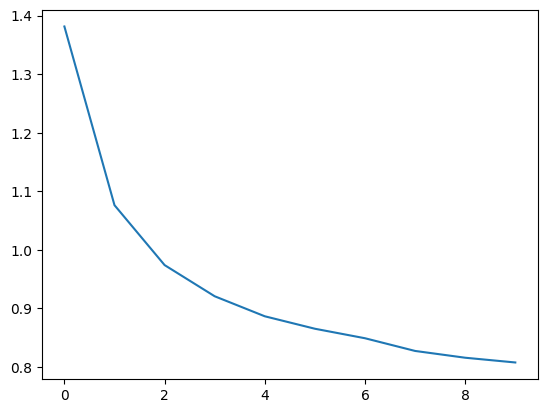

In [22]:
from matplotlib import pyplot as plt
plt.plot(losses)